In [5]:
pip install alibi[tensorflow]

In [6]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout
from tensorflow.keras.layers import Flatten, Input, Reshape, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from alibi.explainers import IntegratedGradients
import matplotlib.pyplot as plt
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # True

TF version:  2.14.1
Eager execution enabled:  True


In [7]:
train, test = tf.keras.datasets.mnist.load_data()
X_train, y_train = train
X_test, y_test = test
test_labels = y_test.copy()
train_labels = y_train.copy()

X_train = X_train.reshape(-1, 28, 28, 1).astype('float64') / 255
X_test = X_test.reshape(-1, 28, 28, 1).astype('float64') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


In [8]:
load_mnist_model = False
save_model = True

In [9]:
filepath = './model_mnist/'  # change to directory where model is saved
if load_mnist_model:
    model = tf.keras.models.load_model(os.path.join(filepath, 'model.h5'))
else:
    # define model
    inputs = Input(shape=(X_train.shape[1:]), dtype=tf.float64)
    x = Conv2D(64, 2, padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)

    x = Conv2D(32, 2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(.5)(x)
    logits = Dense(10, name='logits')(x)
    outputs = Activation('softmax', name='softmax')(logits)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # train model
    model.fit(X_train,
              y_train,
              epochs=6,
              batch_size=256,
              verbose=1,
              validation_data=(X_test, y_test)
              )
    if save_model:
        if not os.path.exists(filepath):
            os.makedirs(filepath)
        model.save(os.path.join(filepath, 'model.h5'))

Epoch 1/6
235/235 [==============================] - 67s 278ms/step - loss: 0.4902 - accuracy: 0.8479 - val_loss: 0.1265 - val_accuracy: 0.9618
Epoch 2/6
235/235 [==============================] - 63s 269ms/step - loss: 0.1696 - accuracy: 0.9475 - val_loss: 0.0784 - val_accuracy: 0.9754
Epoch 3/6
235/235 [==============================] - 63s 269ms/step - loss: 0.1235 - accuracy: 0.9616 - val_loss: 0.0608 - val_accuracy: 0.9826
Epoch 4/6
235/235 [==============================] - 63s 269ms/step - loss: 0.1015 - accuracy: 0.9683 - val_loss: 0.0442 - val_accuracy: 0.9866
Epoch 5/6
235/235 [==============================] - 62s 265ms/step - loss: 0.0882 - accuracy: 0.9725 - val_loss: 0.0407 - val_accuracy: 0.9875
Epoch 6/6
235/235 [==============================] - 63s 266ms/step - loss: 0.0785 - accuracy: 0.9756 - val_loss: 0.0365 - val_accuracy: 0.9886


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
# Initialize IntegratedGradients instance
n_steps = 50
method = "gausslegendre"
ig  = IntegratedGradients(model,
                          n_steps=n_steps,
                          method=method)

In [11]:
# Calculate attributions for the first 10 images in the test set
nb_samples = 10
X_test_sample = X_test[:nb_samples]
predictions = model(X_test_sample).numpy().argmax(axis=1)
explanation = ig.explain(X_test_sample,
                         baselines=None,
                         target=predictions)

In [12]:
# Metadata from the explanation object
explanation.meta

{'name': 'IntegratedGradients',
 'type': ['whitebox'],
 'explanations': ['local'],
 'params': {'target_fn': None,
  'method': 'gausslegendre',
  'n_steps': 50,
  'internal_batch_size': 100,
  'layer': 'unspecified'},
 'version': '0.9.5'}

In [13]:
# Data fields from the explanation object
explanation.data.keys()

dict_keys(['attributions', 'X', 'forward_kwargs', 'baselines', 'predictions', 'deltas', 'target'])

In [14]:
# Get attributions values from the explanation object
attrs = explanation.attributions[0]

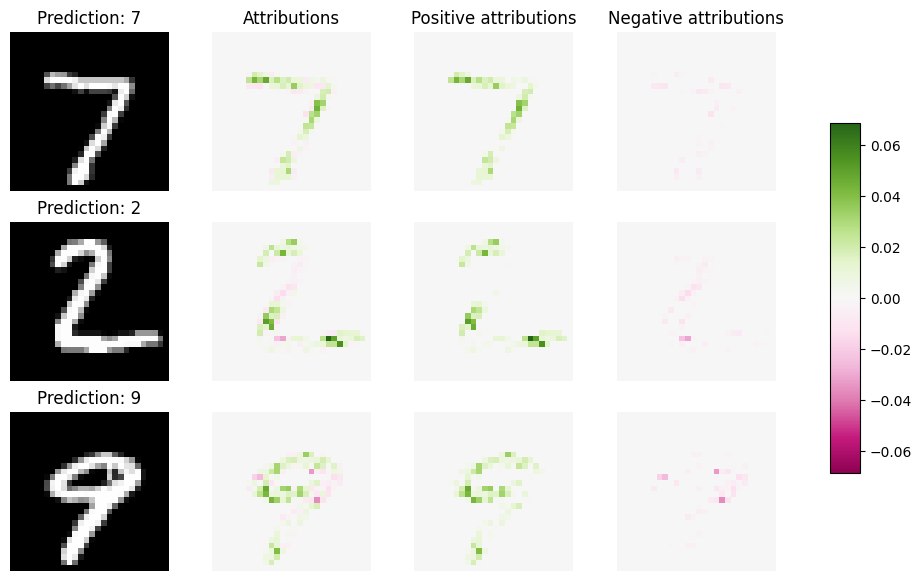

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(10, 7))
image_ids = [0, 1, 9]
cmap_bound = np.abs(attrs[[0, 1, 9]]).max()

for row, image_id in enumerate(image_ids):
    # original images
    ax[row, 0].imshow(X_test[image_id].squeeze(), cmap='gray')
    ax[row, 0].set_title(f'Prediction: {predictions[image_id]}')

    # attributions
    attr = attrs[image_id]
    im = ax[row, 1].imshow(attr.squeeze(), vmin=-cmap_bound, vmax=cmap_bound, cmap='PiYG')

    # positive attributions
    attr_pos = attr.clip(0, 1)
    im_pos = ax[row, 2].imshow(attr_pos.squeeze(), vmin=-cmap_bound, vmax=cmap_bound, cmap='PiYG')

    # negative attributions
    attr_neg = attr.clip(-1, 0)
    im_neg = ax[row, 3].imshow(attr_neg.squeeze(), vmin=-cmap_bound, vmax=cmap_bound, cmap='PiYG')

ax[0, 1].set_title('Attributions');
ax[0, 2].set_title('Positive attributions');
ax[0, 3].set_title('Negative attributions');

for ax in fig.axes:
    ax.axis('off')

fig.colorbar(im, cax=fig.add_axes([0.95, 0.25, 0.03, 0.5]));